# Lompe demo

Demonstration of how to use the lompe code to estimate the ionospheric electrodynamcis in a regional grid.

Start by loading necessary modules:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import lompe

The next step is to set up the cubed sphere grid. Each grid cell will have an unknown model parameter, a curl-free SECS amplitude. Collectively they will define the electric field. The grid should be chosen with a resolution that is good enough that it can capture the spatial veraitions that we are interested in, but not so fine that the SECS pole density is much higher than the data density. 

Start by setting the grid parameters, and plot the grid and coastlines in the region of interest:

(-0.45281544785029526, 0.4466379609682358)

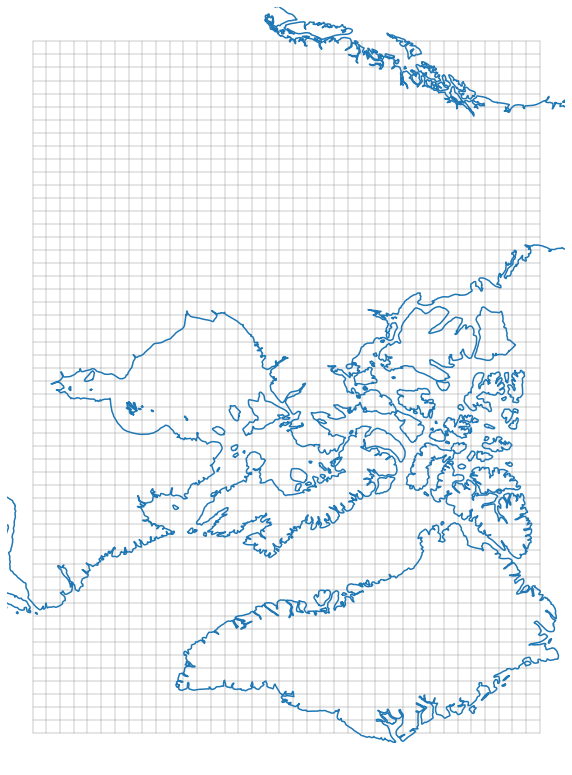

In [2]:
# cubed sphere grid parameters:
position = (-90, 65) # lon, lat for center of the grid
orientation = (-1, 2) # east, north components of vector that defines orientation of grid 
L, W, Lres, Wres = 4200e3, 7000e3, 100.e3, 100.e3 # dimensions and resolution of grid, in meters

# create grid object:
grid = lompe.cs.CSgrid(lompe.cs.CSprojection(position, orientation), L, W, Lres, Wres, R = 6481.2e3)


# Plot grid and coastlines:
fig, ax = plt.subplots(figsize = (10, 14))
ax.set_axis_off()
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color = 'C0')
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)

Next, we load some sample datasets, select a time interval, and remove data that is far away from the grid.

The datasets used here are
- [SuperMAG](https://supermag.jhuapl.edu/) ground magnetometer data (with baseline removed)
- Iridium satellite magnetometer data, provided by [AMPERE](http://ampere.jhuapl.edu/dataraw/index.html), but not their fit output 
- SuperDARN line-of-sight measurements - in a file that includes the line-of-sight vectors - grid files from [published dataset by E.Thomas](https://zenodo.org/record/3618607)

In [3]:
# File names
supermagfn = './sample_dataset/20120405_supermag.h5'
superdarnfn = './sample_dataset/20120405_superdarn_grdmap.h5'
iridiumfn = './sample_dataset/20120405_iridium.h5'

# Load data
iridium   = pd.read_hdf(iridiumfn)
supermag  = pd.read_hdf(supermagfn)
superdarn = pd.read_hdf(superdarnfn)

The data must be passed to the lompe Model object (created later) as lompe Data objects. The idea is to ensure that the data format has been checked. That is currently not implemented, so we just need to set it up exactly as below. To do this, I will write a function that returns subsets of the data, so that I can reuse it later if I want to change time period:

In [4]:
def get_data_subsets(t0, t1):
    """ return subsets of data loaded above, between t0 and t1 """
    
    # Iridium data:
    irid = iridium[(iridium.time >= t0) & (iridium.time <= t1)]
    irid_B = np.vstack((irid.B_e.values, irid.B_n.values, irid.B_r.values))
    irid_coords = np.vstack((irid.lon.values, irid.lat.values, irid.r.values))

    # SuperMAG data:
    smag = supermag.loc[t0:t1, :]
    smag_B = np.vstack((smag.Be.values, smag.Bn.values, smag.Bu.values))
    smag_coords = np.vstack((smag.lon.values, smag.lat.values))
    
    # SuperDARN data:
    sd = superdarn.loc[t0:t1, :]
    vlos = sd['vlos'].values
    sd_coords = np.vstack((sd['glon'].values, sd['glat'].values))
    los  = np.vstack((sd['le'].values, sd['ln'].values))


    
    # Make the data objects. The scale keyword determines a weight for the dataset. Increase it to reduce weight
    #iridium_data   = lompe.Data(irid_B * 1e-9, irid_coords,            datatype = 'space_mag_full', scale = 200 * irid_B.size * 1e-9)
    #supermag_data  = lompe.Data(smag_B * 1e-9, smag_coords,            datatype = 'ground_mag'    , scale = 100 * smag_B.size * 1e-9)
    #superdarn_data = lompe.Data(vlos         , sd_coords  , LOS = los, datatype = 'convection'    , scale = (100000 * len(vlos))**2 )
    
    #'scale' keyword deprecated in favor of 'error' and 'iweight' keywords
    iridium_data   = lompe.Data(irid_B * 1e-9, irid_coords,            datatype = 'space_mag_full', iweight = 1.0, error = 100e-9)
    supermag_data  = lompe.Data(smag_B * 1e-9, smag_coords,            datatype = 'ground_mag'    , iweight = 0.4, error = 10e-9)
    superdarn_data = lompe.Data(vlos         , sd_coords  , LOS = los, datatype = 'convection'    , iweight = 0.0, error = 50)
    return(iridium_data, supermag_data, superdarn_data)


    
t0 = dt.datetime(2012, 4, 5, 2, 0)
t1 = dt.datetime(2012, 4, 5, 2, 5)

iridium_data, supermag_data, superdarn_data = get_data_subsets(t0, t1)



### Conductance

Before we proceed, we need to specify the conductance. In the current Lompe implementation, there are two options:
- Provide conductance data at a set of points, and run a primitive inversion to interpolate to any other point. This does not always work
- Provide functions of (lon, lat) that return conductance

I will use the second option in this demo, so I need to set up such functions. I'm going to use a combination of Hardy model and EUV production. The EUV production is probably quite good, while the Hardy model is very primitive. Code to combine them are provided in the lompe.conductance module, but I need to make wrappers that only depend on lon and lat:

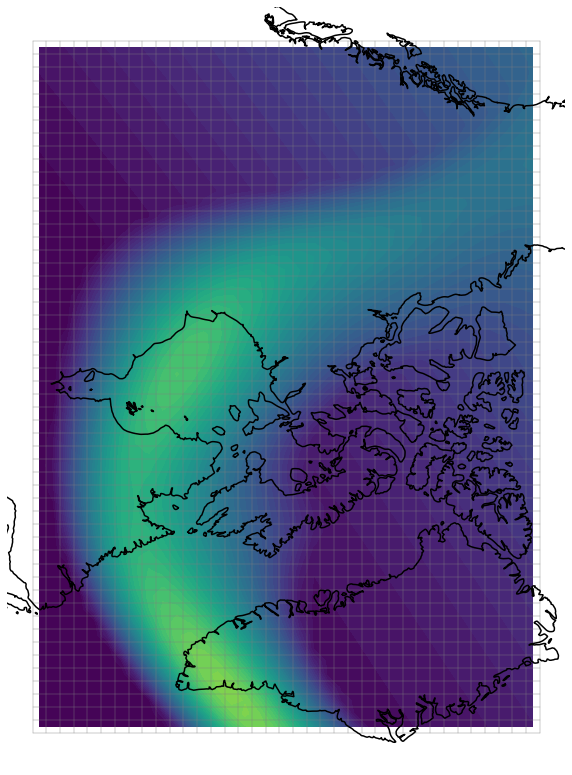

In [5]:
Kp = 4 # This is the input to the Hardy model
t = (t1 - t0)/2 + t0 # used to calculate EUV and MLT

SH = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, t, 'hall')
SP = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, t, 'pedersen')

# plot Hall conductance
fig, ax = plt.subplots(figsize = (10, 14))
ax.set_axis_off()
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color = 'black')
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.contourf(grid.xi, grid.eta, SH(grid.lon, grid.lat), levels = np.linspace(0, 20), extend = 'both')

### Set up model and run inversion

Now we have everything we need to set up the Lompe Model, add data, and run the inversion for the electric field. We plot the output using a function called lompeplot:

In [6]:
# Create Emodel object. Pass grid and Hall/Pedersen conductance functions
model = lompe.Emodel(grid, Hall_Pedersen_conductance = (SH, SP))

# add datasets:
model.add_data(iridium_data)
model.add_data(supermag_data)
model.add_data(superdarn_data)

# Run inversion. l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction
gtg, ltl = model.run_inversion(l1 = 1, l2 = 10)

Finally, plot:

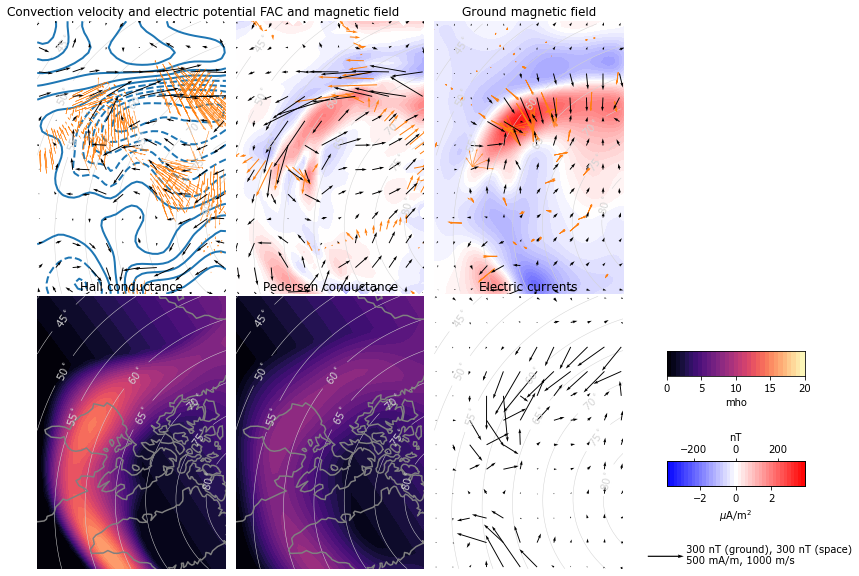

In [7]:
fig = lompe.lompeplot(model, include_data = True)

The coordinate contours are in geographic coordinates. To show magnetic latitude and MLT, plus a polar plot, add an apexpy.Apex object to the lompeplot call, in addition to the model time:

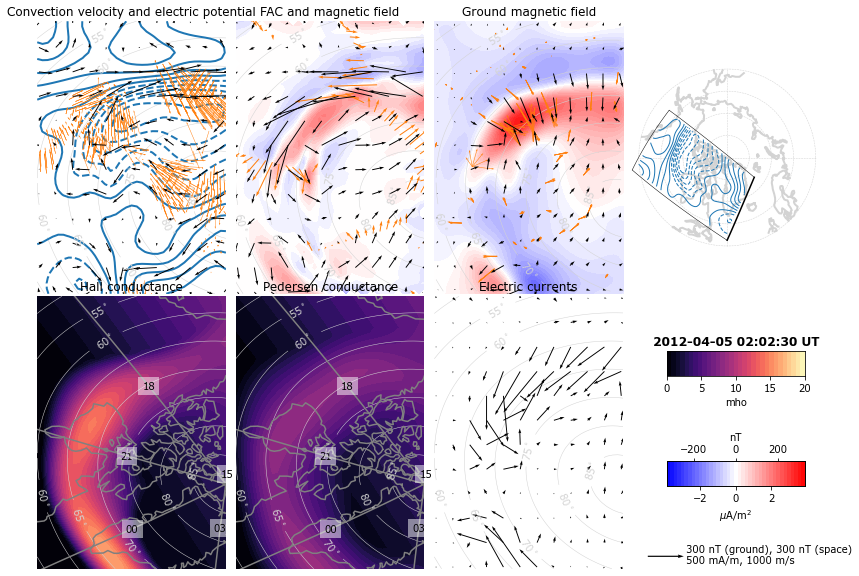

In [8]:
import apexpy
apex = apexpy.Apex(t, refh = 110)
fig = lompe.lompeplot(model, include_data = True, time = t, apex = apex)

The top row shows, from left to right (input data is shown in orange): 
- Convection flow field and electric potential contours
- horizontal magnetic field disturbances 110 km above the ionosphere as black arrows and radial current density as color contours
- horizontal ground magnetic field perturbations as black arrows and radial magnetic field perturbations as color contours
- a map that shows the grid’s position and orientation with respect to apex magnetic latitude and local time.

The bottom row shows, from left to right: 
- Pedersen conductance
- Hall conductance
- horizontal height-integrated ionospheric currents based on Lompe output
- color scale / vector scales

### Repeat for a different time

It is easy to repeat this for a different time as long as that time is contained in the datafile:

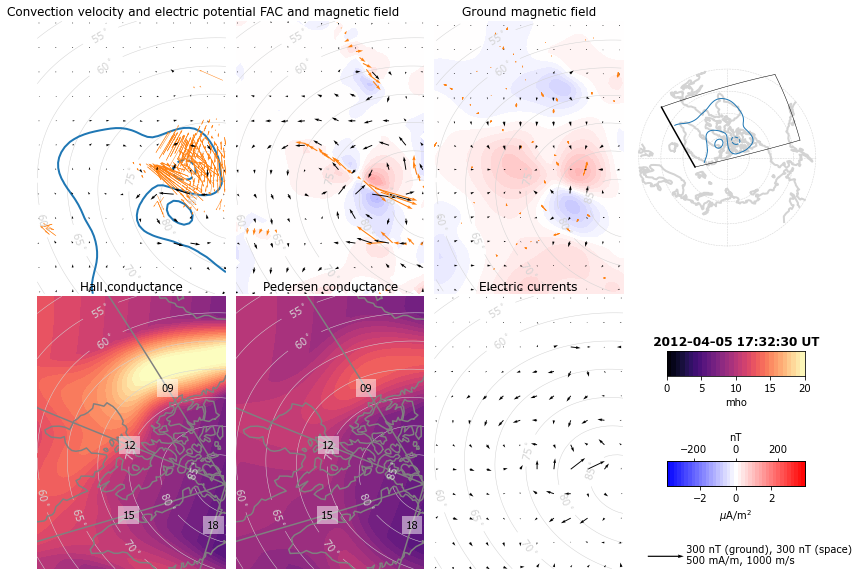

In [9]:
# new time interval:
t0 = dt.datetime(2012, 4, 5, 17, 30)
t1 = dt.datetime(2012, 4, 5, 17, 35)

# get data:
iridium_data, supermag_data, superdarn_data = get_data_subsets(t0, t1)

# define new conductance functions, since the time has changed:
t = (t1 - t0)/2 + t0
SH = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, t, 'hall')
SP = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, t, 'pedersen')

# reset model (delete datasets and clear model vectors)
model.clear_model(Hall_Pedersen_conductance = (SH, SP))

# add new data:
model.add_data(iridium_data)
model.add_data(supermag_data)
model.add_data(superdarn_data)

# run inversion
gtg, ltl = model.run_inversion(l1 = 5, l2 = 0)

# ... and plot
fig = lompe.lompeplot(model, include_data = True, time = t, apex = apex)

This plot shows the same parameters as the one above, but for a different time. Note how the polar plot can be used to easily visualize which MLT sector the model region is locatied in.